# Preparing the environment for EDA

In [30]:
# Imports of Models & libraries. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import nltk
import os
import string   
import re
import squarify
import math

from datetime import datetime
from pywaffle import Waffle
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import column_or_1d
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from textblob import TextBlob
from scipy.stats import norm
from collections import Counter
from nltk import PorterStemmer
from scipy.ndimage import gaussian_gradient_magnitude
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data
inner_london = pd.read_csv('Inner_London.csv')

In [3]:
# View Metadata
inner_london.info()
# 523775 rows of data and 1 row of headers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615168 entries, 0 to 615167
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Survey wave (year)          523776 non-null  float64
 1   Site ID                     523776 non-null  object 
 2   Location                    523776 non-null  object 
 3   Survey date                 521024 non-null  object 
 4   Weather                     519102 non-null  object 
 5   Time                        523770 non-null  object 
 6   Period                      523770 non-null  object 
 7   Direction                   523776 non-null  object 
 8   Start hour                  523770 non-null  float64
 9   Start minute                523770 non-null  float64
 10  Number of private cycles    523776 non-null  float64
 11  Number of cycle hire bikes  523776 non-null  float64
 12  Total cycles                523776 non-null  float64
dtypes: float64(6),

In [4]:
# Look at random sample of data
inner_london.sample(5)

,Survey wave (year),Site ID,Location,Survey date,Weather,Time,Period,Direction,Start hour,Start minute,Number of private cycles,Number of cycle hire bikes,Total cycles
250523,2018.0,INNCY167,Ebury Bridge Road,"mer, 04/07/18",Dry,1245 - 1300,Inter-peak (10:00-16:00),Northbound,12.0,45.0,5.0,1.0,6.0
454104,2021.0,INNCY129,Grosvenor Place,"ven, 21/05/21",Wet,1200 - 1215,Inter-peak (10:00-16:00),Southbound,12.0,0.0,3.0,0.0,3.0
306301,2019.0,INNCY005,Seven Sisters Road,"jeu, 11/07/19",Dry,2115 - 2130,Evening (19:00-22:00),Southbound,21.0,15.0,2.0,0.0,2.0
107625,2016.0,INNCY244,North Road,"mar, 12/04/16",Dry,1615 - 1630,PM peak (16:00-19:00),Westbound,16.0,15.0,1.0,0.0,1.0
141001,2016.0,INNCY505,Candahar Road,"mar, 10/05/16",Wet,0815 - 0830,AM peak (07:00-10:00),Southbound,8.0,15.0,1.0,0.0,1.0


# Data Wrangling

In [5]:
# Rename columns to remove space in column names
inner_london.columns = inner_london.columns.str.replace(' ','_')

In [6]:
# Parse Dates correctly
# Remove French Day name in Survey Date 
inner_london["Survey_date"] = inner_london["Survey_date"].str.replace(r'\D+', '', regex=True)

# Convert to datetime format
inner_london['Survey_date'] = pd.to_datetime(inner_london.Survey_date)

# Define day of the week in English and add back as a column
inner_london['Day_of_week'] = inner_london['Survey_date'].dt.day_name()

# Pass Month into a new column
inner_london['month'] = inner_london['Survey_date'].dt.month

In [7]:
# Pass Season
# Create function for user defined seasons
def f(x):
    if (x >= 1) and (x <= 2):
        return 'Winter'
    elif (x > 2) and (x <= 5 ):
        return 'Spring'
    elif (x > 5) and (x <= 8):
        return'Summer'
    elif (x > 8) and (x <= 11) :
        return 'Autumn'
    elif (x > 11):
        return'Winter'

# Apply user defined function to create new column with seasons
inner_london['season'] = inner_london['month'].apply(f)

In [8]:
# Check missing values
inner_london.isnull().sum()

# Relatively large number of empty row values. 
# Drop the ones without survey date.

Survey_wave_(year)            91392
Site_ID                       91392
Location                      91392
Survey_date                   94144
Weather                       96066
Time                          91398
Period                        91398
Direction                     91392
Start_hour                    91398
Start_minute                  91398
Number_of_private_cycles      91392
Number_of_cycle_hire_bikes    91392
Total_cycles                  91392
Day_of_week                   94144
month                         94144
season                        94144
dtype: int64

In [9]:
# Drop rows if missing values in Survey_date column
inner_london = inner_london.dropna(subset=['Survey_date'])

In [10]:
# Recheck output
inner_london.isnull().sum()

# Can see 4482 rows where missing value from weather is uniquely missing. Will come back.
# Few more missing values in time. Investigate Further.

Survey_wave_(year)               0
Site_ID                          0
Location                         0
Survey_date                      0
Weather                       4482
Time                             6
Period                           6
Direction                        0
Start_hour                       6
Start_minute                     6
Number_of_private_cycles         0
Number_of_cycle_hire_bikes       0
Total_cycles                     0
Day_of_week                      0
month                            0
season                           0
dtype: int64

In [11]:
# Extract row to see whats going on with missing values in time
print(inner_london[inner_london['Time'].isnull()])

        Survey_wave_(year)   Site_ID       Location Survey_date Weather Time  \
513536              2021.0  INNCY536  Hackney Downs  2021-06-23   Sunny  NaN   
513537              2021.0  INNCY536  Hackney Downs  2021-06-23     Dry  NaN   
513538              2021.0  INNCY536  Hackney Downs  2021-06-23   Sunny  NaN   
513539              2021.0  INNCY536  Hackney Downs  2021-06-23     Dry  NaN   
513540              2021.0  INNCY536  Hackney Downs  2021-06-23   Sunny  NaN   
513541              2021.0  INNCY536  Hackney Downs  2021-06-23     Dry  NaN   

       Period   Direction  Start_hour  Start_minute  Number_of_private_cycles  \
513536    NaN  Northbound         NaN           NaN                       7.0   
513537    NaN  Northbound         NaN           NaN                       7.0   
513538    NaN  Northbound         NaN           NaN                      15.0   
513539    NaN  Northbound         NaN           NaN                      15.0   
513540    NaN  Northbound         

In [12]:
# We see time not recorded. Given how small the effected sample size is we remove them.
inner_london = inner_london.dropna(subset=['Time'])

In [13]:
# View Metadata now
inner_london.info()
# 521017 rows of data
# 2758 rows of data were either empty altogether, didnt have data in Surve Date or Time.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521018 entries, 0 to 523775
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Survey_wave_(year)          521018 non-null  float64       
 1   Site_ID                     521018 non-null  object        
 2   Location                    521018 non-null  object        
 3   Survey_date                 521018 non-null  datetime64[ns]
 4   Weather                     516536 non-null  object        
 5   Time                        521018 non-null  object        
 6   Period                      521018 non-null  object        
 7   Direction                   521018 non-null  object        
 8   Start_hour                  521018 non-null  float64       
 9   Start_minute                521018 non-null  float64       
 10  Number_of_private_cycles    521018 non-null  float64       
 11  Number_of_cycle_hire_bikes  521018 non-

In [14]:
# Drop rows where total cycles doesnt add up to number of private and hire cycles.
# Creating a column to add up the values
inner_london['Sum'] = inner_london['Number_of_private_cycles'] + inner_london['Number_of_cycle_hire_bikes']

# Dropping rows where the column values dont add up 
inner_london = inner_london[inner_london.Total_cycles == inner_london.Sum]

# Look at output
inner_london.info()

# 152 rows dropped where total cycles doesnt add up

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520866 entries, 0 to 523775
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Survey_wave_(year)          520866 non-null  float64       
 1   Site_ID                     520866 non-null  object        
 2   Location                    520866 non-null  object        
 3   Survey_date                 520866 non-null  datetime64[ns]
 4   Weather                     516384 non-null  object        
 5   Time                        520866 non-null  object        
 6   Period                      520866 non-null  object        
 7   Direction                   520866 non-null  object        
 8   Start_hour                  520866 non-null  float64       
 9   Start_minute                520866 non-null  float64       
 10  Number_of_private_cycles    520866 non-null  float64       
 11  Number_of_cycle_hire_bikes  520866 non-

In [15]:
# Drop the redundant columns to reduce size of dataFrame & memomry consumption
inner_london.drop(['Sum', 'Start_hour', 'Start_minute', 'month'], axis=1)

,Survey_wave_(year),Site_ID,Location,Survey_date,Weather,Time,Period,Direction,Number_of_private_cycles,Number_of_cycle_hire_bikes,Total_cycles,Day_of_week,season
0,2015.0,INNCY001,Grove Road,2015-05-20,Dry,0600 - 0615,Early Morning (06:00-07:00),Northbound,1.0,0.0,1.0,Wednesday,Spring
1,2015.0,INNCY001,Grove Road,2015-05-20,Dry,0615 - 0630,Early Morning (06:00-07:00),Northbound,2.0,0.0,2.0,Wednesday,Spring
2,2015.0,INNCY001,Grove Road,2015-05-20,Dry,0630 - 0645,Early Morning (06:00-07:00),Northbound,2.0,0.0,2.0,Wednesday,Spring
3,2015.0,INNCY001,Grove Road,2015-05-20,Dry,0645 - 0700,Early Morning (06:00-07:00),Northbound,4.0,0.0,4.0,Wednesday,Spring
4,2015.0,INNCY001,Grove Road,2015-05-20,Dry,0700 - 0715,AM peak (07:00-10:00),Northbound,4.0,0.0,4.0,Wednesday,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...
523771,2021.0,INNCY597,Augustus Road,2021-05-26,Dry,2045 - 2100,Evening (19:00-22:00),Westbound,3.0,0.0,3.0,Wednesday,Spring
523772,2021.0,INNCY597,Augustus Road,2021-05-26,Dry,2100 - 2115,Evening (19:00-22:00),Westbound,2.0,0.0,2.0,Wednesday,Spring
523773,2021.0,INNCY597,Augustus Road,2021-05-26,Dry,2115 - 2130,Evening (19:00-22:00),Westbound,2.0,0.0,2.0,Wednesday,Spring
523774,2021.0,INNCY597,Augustus Road,2021-05-26,Dry,2130 - 2145,Evening (19:00-22:00),Westbound,2.0,0.0,2.0,Wednesday,Spring


In [16]:
# Drop the decimal point in Survey_wave
inner_london['Survey_wave_(year)'] = inner_london['Survey_wave_(year)'].astype(str).apply(lambda x: x.replace('.0','')).astype(int)

In [17]:
# Count unique values in each column
for col in inner_london:
  print(col,": ", inner_london[col].nunique())

# More site ids vs location
# May imply multiple sites in same location. Does this double count? Need to check!
# Survey period of over 7 years
# 5 Periods of day which should be synched in same fashion with all the other city count data
# will use london period of day definition as base.
# 165 types of weather needs to be discussed and trimmed with team

Survey_wave_(year) :  7
Site_ID :  597
Location :  584
Survey_date :  463
Weather :  165
Time :  64
Period :  5
Direction :  4
Start_hour :  16
Start_minute :  4
Number_of_private_cycles :  221
Number_of_cycle_hire_bikes :  28
Total_cycles :  233
Day_of_week :  7
month :  12
season :  4
Sum :  233


In [18]:
# Explore the different types of Weather
print(inner_london.Weather.unique())

# Lots of overlaps for e.g. Rain & Wet, Dry/cold and dry Cold.
# Need to classify into much narrower streams. 
# Discuss with team tomorrow & then initiate replacements.
# Doing the obvious ones now

['Dry' 'Dry                         9' 'Wet' 'Warm + Dry' nan 'S.wet'
 'S/w' 'Sunny' 'Cloudy/sunny' 'Cloudy' 'Cloudy/rain' 'Cloudy/dry' 'Rain'
 'Druy' 'Mix Wet/dry' 'Drizzle' 'Dry & Windy' 'Light Showers' 'Dry/hot'
 'Sun' 'Fine' 'Very Windy' 'Mizzle' 'Windy/rain' 'Dry Warm' 'Showers'
 'Wet/dry' 'High Wind' 'Dry Wet Road' 'Wet/damp' 'Dry/sunny' 'Dark/cloudy'
 'Shower' 'Dry/sun' 'Dry/overcast' 'Overcast' 'Light Rain' 'Shower/dry'
 'Down Pour' 'Sleet' 'Wet (shower)' 'Spitting' 'Dry Sunny' 'Heavy Rain'
 'Drizzle/cloudy' 'Dry/wet' 'Dull' 'Damp' 'Cloud' 'Dry/drizzle' 'Fair'
 'Rain/sleet' 'Dry Cold' 'Dull/damp' 'Hail Stone' 'Hot' 'Dry-wet' 'N/a'
 'Too Cold' 'Overcast/dry' 'Bright/dry' 'Overcast/rain Heavy Showers'
 'Heavy Thunder' 'Wet/mix' 'Thunder' 'Sun/cloudy' 'Snow' 'Dry/cloudy'
 'Dry Road Still Wet' 'Windy' 'Drizzle/wet' 'Sunny (hot!)' 'Wet/windy'
 'Dry/v. Windy' 'Warm/dry' 'Rain Shower' 'Intermittent Showers'
 'Cloudy/drizzle' 'Rain/drizzle' 'Cloudy/sun' 'Cloudy Sun' 'Hail'
 'Wet Road' 

In [19]:
# Replace some obvious duplications in Weather
# Rain
inner_london['Weather'] = inner_london['Weather'].replace(['Wet','Cloudy/rain','Rain','Mix Wet/dry','Drizzle',
                                                          'Light Showers', 'Mizzle','Windy/rain','Showers',
                                                          'Wet/dry','Wet/damp','Shower','Drizzle/shower','Rainy',
                                                          'wet','Cloudy with showers','Generally overcast brief shower'
                                                          'Light Rain','Shower/dry','Spitting','Drizzle/cloudy',
                                                          'Dry/wet','Damp', 'Dry/drizzle','Dull/damp','Dry-wet',
                                                          'Wet/mix', 'Drizzle/wet','Wet/windy','Rain Shower',
                                                          'Intermittent Showers','Cloudy/drizzle','Rain/drizzle',
                                                          'Wet Road','Drizzle/dry','Drizzle/rain','Mixed Sunny + Rain',
                                                          'Wet/rain', 'V Light Drizzle', 'Rainy', 'W','Slight Drizzle',
                                                          'Rain Stopped', 'Stopped Raining','Wet Rain Stopped','Raining/wet',
                                                          'Showery','Overcast/rain','Rain/wet','Rain/showers','Showers/sunny',
                                                          'Drizzle/showers','Wet/stop Raining','Drizzle Rain','Drizzle Wet',
                                                          'Damp/sun','Raining','Dry + Wet','Showers/cloudy','Cloudy/showers',
                                                          'Getting Wet','Wet Road:sun','Dry But Wet Road','Drizze',
                                                          'wet','Wettish','Light Rain','S.wet','S/w',
                                                          'Heavy Rain','Heavy Shower','Heavy Shr','Down Pour',
                                                           'Deluge','Heavy Showers', 'Shower','Rain Heavy Showers',
                                                           'Intermitent Showers','Thunder Lightening Rain!','Very Wet',
                                                           'V.wet','Heavy Downpour/rain','Showery','Wet Heavy Rain',
                                                           'Wet (heavy Rain)','Wet (shower)'],'Rain')

# Good
inner_london['Weather'] = inner_london['Weather'].replace(['Sunny','Cloudy Sunny','Sun Setting','Good','Dry/sunny',
                                                          'Fine + Dry', 'Fine + Hot','Bright','Dry Hot!!',
                                                          'Dry & Sunny','Dry & Sun','Fine & Dry','Good/dry','Sun',
                                                          'Sunny Dry','Clear and Bright', 'Fine', 'Dry/good', 
                                                          'Fine/dry', 'Warm + Dry','Dry','Dry                         9',
                                                          'Sunny','Cloudy/sunny','Druy','Dry/hot','Dry Warm',
                                                          'Dry/sun','Dryish','Clear And Dry','Clear and Dry','Dry, Warm',
                                                          'Dry, Sunny, Warm','Cloudy with Clear Intervals','Clear and Warm',
                                                          'Dry But Misty','Sunny & Warm All Day','Clear','Dry + Sunny',
                                                          'Sunny/dry','Dr Ry','Dry Y','D','Warm/dry','Bright/dry','Dry Sunny',
                                                          'Fair','Dry/sun','Cloudy','Sunny Overcast Sunny','Sunny/cloudy','Cloudy/rain/sunny',
                                                           'Cloudy + Sunny','Sunny + Cloudy', 'Cloudy/sunny',
                                                           'Bright + Cloudy','Cloudy/dry','Partly Sunny','Dull','Dry & Mild',
                                                           'Cloud','Overcast','Mild','Overcast (No Rain)',
                                                          'Cloudy bright intervals','Generally overcast',
                                                           'Cloudy with clear spells','Sunny Overcast','Dry',
                                                           'Dry/mild', 'Clear','Cloudy and Dry','Partly cloudy but dry',
                                                          'Partly cloudy and dry','Cloudy but dry','Partly cloudy and Dry',
                                                          'Sun/Cloudy','Clouds & Sunny','Sun/clouds','Cloudy & Sunny',
                                                          'Sun & Clouds','Cloudy Dry','Cloud/sun','Mixed','Sun/cloud',
                                                           'Sunny/cloudy','Cloudy Sun','Cloudy/sun','Dry/cloudy',
                                                           'Sun/cloudy','Overcast/dry','Cloud','Dull','Dry/overcast',
                                                          'Dark/cloudy','Cloudy/dry','Cloudy'],'Good')



# Damp
inner_london['Weather'] = inner_london['Weather'].replace(['Wet/dry','Intermittent Light Drizzle','Light Rain',
                                                           'Lt Rain','Drizzle','Intermittent Drizzle', 'Damp','Getting Dry',
                                                           'Dry & Wet','Slight Drizzle/dry','Dry Road Still Wet'],'Damp')

# Dangerous Conditions
inner_london['Weather'] = inner_london['Weather'].replace(['Heavy Rain','Dry/wet Road','Dry With Wet Road',
                                                           'Hot','Snow!','Snow', 'Sleet','Very Hot',
                                                           'Dry (road Wet)','Dry, Sunny, Hot','Very Heavy Rain',
                                                           'Intermittent Heavy Showers','Very Hot/dry','Hot/dry',
                                                           'Storm','Heavy Rain High Winds','V Wet','Rain Heavy',
                                                          'Sunny (hot!)','Heavy Thunder','Overcast/rain Heavy Showers',
                                                          'Too Cold','High Wind','Very Windy','Wet/windy','Wet/v.windy',
                                                           'Wet Hail','Rain/hail','Foggy Wet',
                                                           'Wet Heavy Wind', 'Wet-windy','Hailstones',
                                                           'Short Hail Shower','Rain/sleet','Hail Stone',
                                                          'Hail','Showers/hailstone','Rain/hailstone','Dry Chill','Dry/cold',
                                                           'Dry Cold','Cold/sunny','Cold/cloudy',
                                                           'Dry Very Windy', 'Dry/windy','Windy','Cold','Cloudy/windy',
                                                           'Windy + Sunny','Sunsetting + Windy','Dark Cloudy',
                                                           'Dry V. Cold!','Very Cool','Dry & Windy',
                                                          'Dry but Cold or Wind','Dry/v. Windy','Dry Windy',
                                                          'Windy At First Then Sunny','Windy Dry',
                                                          'Dry Wet Road','Thunder'],'Dangerous_Conditions')

# Consolidating 'Unknown'
inner_london['Weather'] = inner_london['Weather'].replace(['School Out','N/a','Unknown'],'Unknown')

# Transforming Nan Values into Unknown
# Replacing nan with 'Unknown'
inner_london.Weather = inner_london.Weather.fillna('Unknown')

# Consolidating "Dry Dark" into "Unknown"
inner_london['Weather'] = inner_london['Weather'].replace(['Dry Dark','Dry/dark','Dark/dry',
                                                           'Dark Dry'],'Unknown')

In [20]:
# Check output
print(inner_london.Weather.unique())

# Discuss the rest

['Good' 'Rain' 'Unknown' 'Dangerous_Conditions' 'Damp']


# Basic Visualisations

## How has cycling evolved over time?

In [21]:
# Aggregate data by survey year
df= inner_london.groupby(['Survey_wave_(year)'], as_index=False)['Total_cycles'].sum()
df


,Survey_wave_(year),Total_cycles
0,2015,448419.0
1,2016,440656.0
2,2017,441927.0
3,2018,455721.0
4,2019,447601.0
5,2020,428868.0
6,2021,567467.0


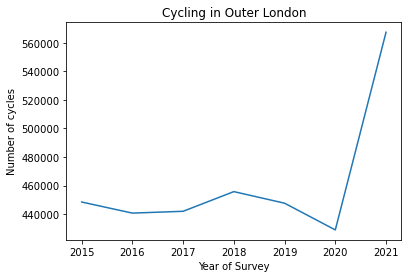

In [22]:
# Create the line chart
plt.plot(df['Survey_wave_(year)'], df['Total_cycles'])

# Adding the aesthetics
plt.title("Cycling in Outer London")
plt.xlabel('Year of Survey')
plt.ylabel('Number of cycles')

# Show the plot
plt.show()

## Does the time of the day matter?

In [23]:
# Aggregate by time of day

df= inner_london.groupby(['Period'], as_index=False)['Total_cycles'].sum()
df.sort_values('Total_cycles', inplace = True)

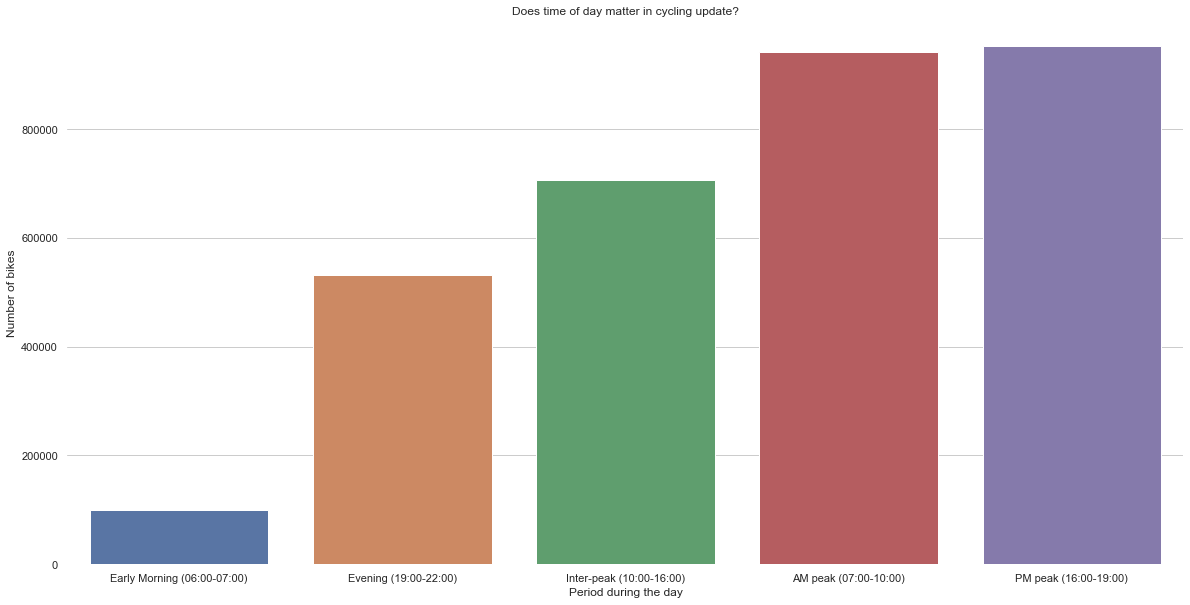

In [24]:
# Chart to view time of day with highest cycling count
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialise matplotlib fiture
f, g = plt.subplots(figsize = (20,10))

g=sns.barplot(x = df['Period'], y = df['Total_cycles'])

# Add legend and add title etc
g.set(ylabel = "Number of bikes",
     xlabel = "Period during the day")
g.set_title('Does time of day matter in cycling update?')
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()



## Do Seasons matter?

In [25]:
# Aggregate data by Weather
df= inner_london.groupby(['season'], as_index=False)['Total_cycles'].sum()
df

,season,Total_cycles
0,Autumn,661970.0
1,Spring,1268175.0
2,Summer,1060293.0
3,Winter,240221.0


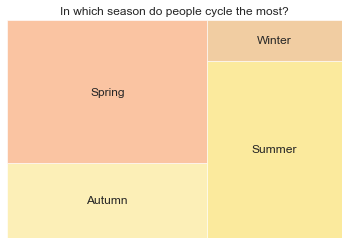

In [26]:
# Plotting a treemap
# Colour Palette
colors=['#fae588','#f79d65','#f9dc5c','#e8ac65','#e76f51','#ef233c','#b7094c']

# Set Plot Style
sns.set_style(style="whitegrid") 

# Setting the variable
sizes= df["Total_cycles"].values
label=df["season"]

# Setting the styles
squarify.plot(sizes=sizes, label=label, alpha=0.6,color=colors).set(title='In which season do people cycle the most?')
plt.axis('off')
plt.show()

# Need to ask Kevin to prettify
# Explore waffle charts
# May be corrupted by the fact that most of the data is collected during spring and summer

## Does Weather matter?

In [27]:
# Aggregate data by Weather
df= inner_london.groupby(['Weather'], as_index=False)['Total_cycles'].sum()
df

,Weather,Total_cycles
0,Damp,458.0
1,Dangerous_Conditions,7464.0
2,Good,2882878.0
3,Rain,308882.0
4,Unknown,30977.0


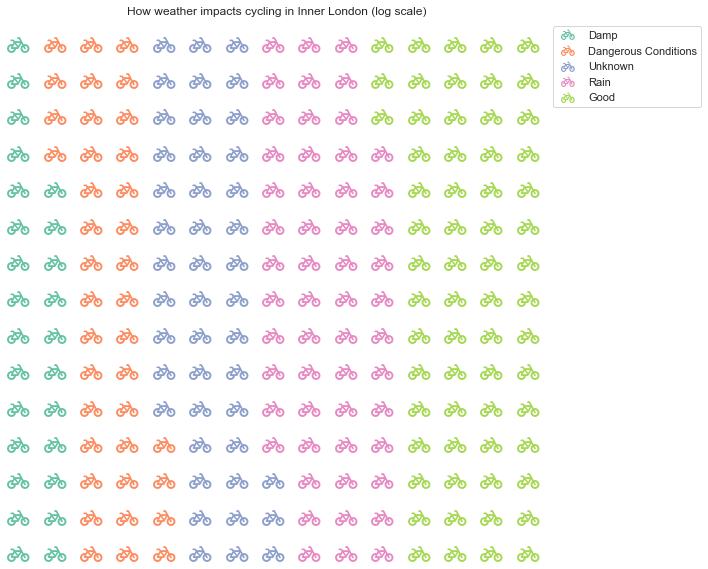

In [31]:
# Plot Waffle Chart
# Change to log scale
data = {'Damp': math.log(458), 'Dangerous Conditions': math.log(7464), 'Unknown': math.log(30977), 'Rain': math.log(308882), 
        'Good': math.log(2882878)}
fig = plt.figure(FigureClass = Waffle, rows = 15, columns = 15, values = data, 
                 title = {'label': 'How weather impacts cycling in Inner London (log scale)'}, 
                 legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)}, 
                 figsize = (10,15), icons='bicycle', icon_size=18, icon_legend=True)

# May not be doable when all the dataframes are merged
# Ask Kevin to see if he can prettify

In [ ]:
# Explore other Variables

In [ ]:
# Merge all three london DataFrames

## What do people think about Cycling?

In [ ]:
# Do sentiment analysis